# Data Exploration and Pre-Processing

This dataset contains chest x-ray images some of which are labeled as 'NORMAL' and otheras as 'PNEUMONIA' which are examples of patients that indeed have a case the potentially lethal respiratory infection. There are 5656 total images in a range of dimensions and all are greyscale. The dataset is sourced directly from [this Kaggle page](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) using the Kaggle API command (kaggle datasets download -d paultimothymooney/chest-xray-pneumonia). This kaggle page cites [Mendeley Data](https://data.mendeley.com/datasets/rscbjbr9sj/2) as its original data source.  

## Data loading and sifting

In [1]:
# dependences for data loading and sifting
import numpy as np 
import pandas as pd 

import os
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [2]:
# file paths to data directories
train_dir = "data/train/"
test_dir = "data/test/"
val_dir = "data/val/"

# dictionary of volume of data per class per sample
class_balance_dict = {
    "Train Sample":[len(os.listdir(train_dir+"NORMAL")),len(os.listdir(train_dir+"PNEUMONIA"))],
    "Test Sample":[len(os.listdir(test_dir+"NORMAL")),len(os.listdir(test_dir+"PNEUMONIA"))],
    "Val Sample":[len(os.listdir(val_dir+"NORMAL")),len(os.listdir(val_dir+"PNEUMONIA"))]
}

# class balance dictionary as a dataframe with row index representing class and column index representing sample
import pandas as pd
class_balance_df = pd.DataFrame(class_balance_dict,index=['Normal', 'Pneumonia'])
class_balance_df

,Train Sample,Test Sample,Val Sample
Normal,1341,234,8
Pneumonia,3875,390,8


Text(0, 0.5, 'Percent Class Representation')

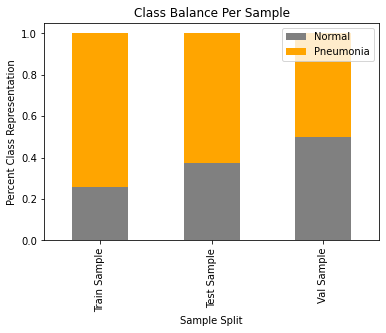

In [3]:
import matplotlib.pyplot as plt

# normalize data as percentage and rotate for plotting
class_balance_normalized = class_balance_df.T.apply(lambda x: x/x.sum(), axis=1)
 
# create stacked bar chart for students DataFrame
class_balance_normalized.plot(kind='bar', stacked=True, color=['gray', 'orange',])

# Add Title and Labels
plt.title('Class Balance Per Sample')
plt.xlabel('Sample Split')
plt.ylabel('Percent Class Representation')

The data comes already labeled and split for 3 way validation. The Train sample is, naturally, the largest of the 3 with over five thousand images, 66% of which are cases of pneumonia which will be the target prediction. The next largest is the test sample with over six hundred images of which 40% are trues cases of pneumonia. Finally, the validation set contains 16 images with each class being represented equally at 50%.  

## Sanity Check: Can the images be displayed easily?

In [4]:
# an example of (first) and Normal x-ray scan and (second) and x-ray scan showing pneumonia
Image.open("data/train/NORMAL/IM-0115-0001.jpeg").show()
Image.open("data/train/PNEUMONIA/person1001_bacteria_2932.jpeg").show()

## Generate Data from Sub-Directory Structure

In [5]:
# dependencies for modeling
from keras import layers
from keras import models
from keras import optimizers

In [6]:
# instatiating a data degenerater for each split sample 
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)
                                   
val_datagen = ImageDataGenerator(rescale=1./255)

train_data_generator = train_datagen.flow_from_directory(
                       train_dir,
                       target_size=(150,150),
                       batch_size=16,
                       class_mode='binary',
                       color_mode='grayscale')

test_data_generator = test_datagen.flow_from_directory(
                      test_dir,
                      target_size=(150,150),
                      batch_size=16,
                      class_mode='binary',
                      color_mode='grayscale')

val_data_generator = val_datagen.flow_from_directory(
                     val_dir,
                     target_size=(150,150),
                     batch_size=16,
                     class_mode='binary',
                     color_mode='grayscale')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Sanity Check: is the data ready to fit a model?

In [11]:
# build a simple convultional neural network
base_model = models.Sequential()
base_model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
base_model.add(layers.MaxPooling2D((2, 2)))
base_model.add(layers.Flatten())
base_model.add(layers.Dense(1, activation='sigmoid'))

In [12]:
# compile model from above
base_model.compile(loss='binary_crossentropy',metrics=['acc'])

In [13]:
# fit the model to the training data and validate with the test sample
base_model.fit(train_data_generator, 
               batch_size=16,
               epochs=10,
               steps_per_epoch=25,
               validation_data=test_data_generator,
               validation_steps=15
               )

Epoch 1/10
25/25 [==============================] - 11s 456ms/step - loss: 1.4643 - acc: 0.6975 - val_loss: 0.5211 - val_acc: 0.7083
Epoch 2/10
25/25 [==============================] - 10s 409ms/step - loss: 0.5715 - acc: 0.8100 - val_loss: 0.8651 - val_acc: 0.6500
Epoch 3/10
25/25 [==============================] - 10s 394ms/step - loss: 0.3292 - acc: 0.8575 - val_loss: 0.4289 - val_acc: 0.7583
Epoch 4/10
25/25 [==============================] - 10s 401ms/step - loss: 0.2931 - acc: 0.8975 - val_loss: 0.3893 - val_acc: 0.8083
Epoch 5/10
25/25 [==============================] - 10s 399ms/step - loss: 0.2597 - acc: 0.9100 - val_loss: 0.5456 - val_acc: 0.7208
Epoch 6/10
25/25 [==============================] - 10s 405ms/step - loss: 0.1739 - acc: 0.9325 - val_loss: 0.4969 - val_acc: 0.7625
Epoch 7/10
25/25 [==============================] - 10s 400ms/step - loss: 0.1859 - acc: 0.9400 - val_loss: 0.3011 - val_acc: 0.8833
Epoch 8/10
25/25 [==============================] - 10s 393ms/step - 

## Sanity Check: can the data be evaluated?

In [18]:
X_test, y_test = test_data_generator.next()
loss, accuracy = base_model.evaluate(X_test,y_test)

1/1 [==============================] - 0s 4ms/step - loss: 1.2235 - acc: 0.6250


              precision    recall  f1-score   support

         0.0       1.00      0.25      0.40         8
         1.0       0.57      1.00      0.73         8

    accuracy                           0.62        16
   macro avg       0.79      0.62      0.56        16
weighted avg       0.79      0.62      0.56        16



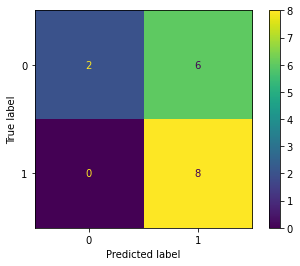

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# generate predictions for the test set
y_pred = np.round(base_model.predict(X_test))

# calculate the confusion matrix and classification report
matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test,y_pred)

# create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(matrix)

# plot the confusion matrix, print the classification report
print(report)
disp.plot()
plt.show()

Formalize the model evaluation protocol above into a function for portability. 

In [30]:
def evaluate_model_performance(model,data_generator,verbose=True):
    """
    Takes in a keras model object and ImageDataGenerator object
    Samples a batch from the data generator
    Calcultes key performance indicators (KPIs)
    Prints loss and classification_report, and plots a confusion matrix
    If not verbose, returns loss, classification_report and confusion_matrix
    """
    
    # declare evaluation sample
    X_test, y_test = data_generator.next()

    # insantiate test prediction
    y_pred = np.round(model.predict(X_test))

    # evaluate KPIs
    loss, accuracy = model.evaluate(X_test,y_test)

    # calculate the confusion matrix and classification report
    matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test,y_pred)

    # create a ConfusionMatrixDisplay object
    disp = ConfusionMatrixDisplay(matrix)

    # print loss and KPI scores
    print("Model loss: ",loss)
    print("KPI scores: ",report)

    # plot confusion matrix
    disp.plot()
    plt.show()

    if not verbose:
        return loss, report, matrix

    

1/1 [==============================] - 0s 1ms/step - loss: 1.1741 - acc: 0.6250
Model loss:  1.1741056442260742
KPI scores:                precision    recall  f1-score   support

         0.0       1.00      0.14      0.25         7
         1.0       0.60      1.00      0.75         9

    accuracy                           0.62        16
   macro avg       0.80      0.57      0.50        16
weighted avg       0.77      0.62      0.53        16



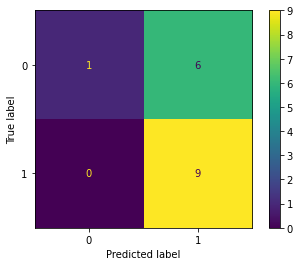

In [32]:
evaluate_model_performance(base_model,test_data_generator) 

## Conlcusion 
The base model succesfully compiles and fits without any errors or warnings. The model also performs decently for a baseline model. I will continue tuning and optimizing thhe model in the [modeling notebook](/PROJECT-2/modeling.ipynb).  